# Product Sales Forecasting: Holt-Winters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

In [ ]:
path = '/content/drive/MyDrive/Product Sales Forecasting/data/'

# Get train and test data using 'date' as the index
train = pd.read_csv(f'{path}train.csv', usecols=['date', 'qty'], index_col='date', parse_dates=True)
test = pd.read_csv(f'{path}test.csv', usecols=['date', 'qty', 'closed_day'], index_col='date', parse_dates=True)

# Get list of closed days for test data, and drop 'closed_day' column
test_closed_days = test[test['closed_day'] == 1].index
test = test.drop('closed_day', axis=1)

In [ ]:
train.describe()

,qty
count,1980.000000
mean,6.278283
std,4.474715
min,0.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,36.000000


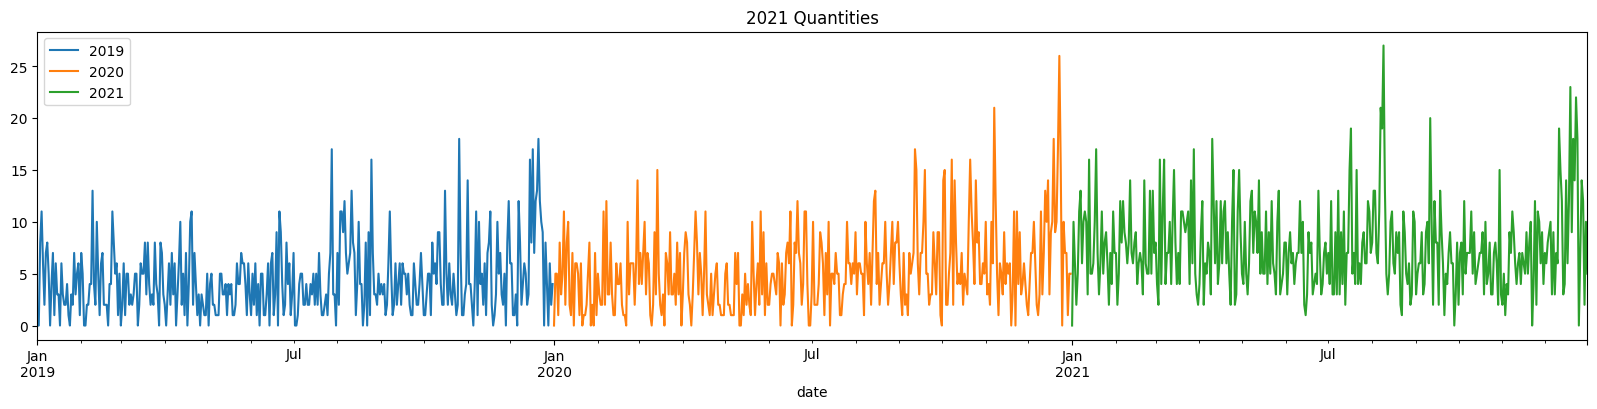

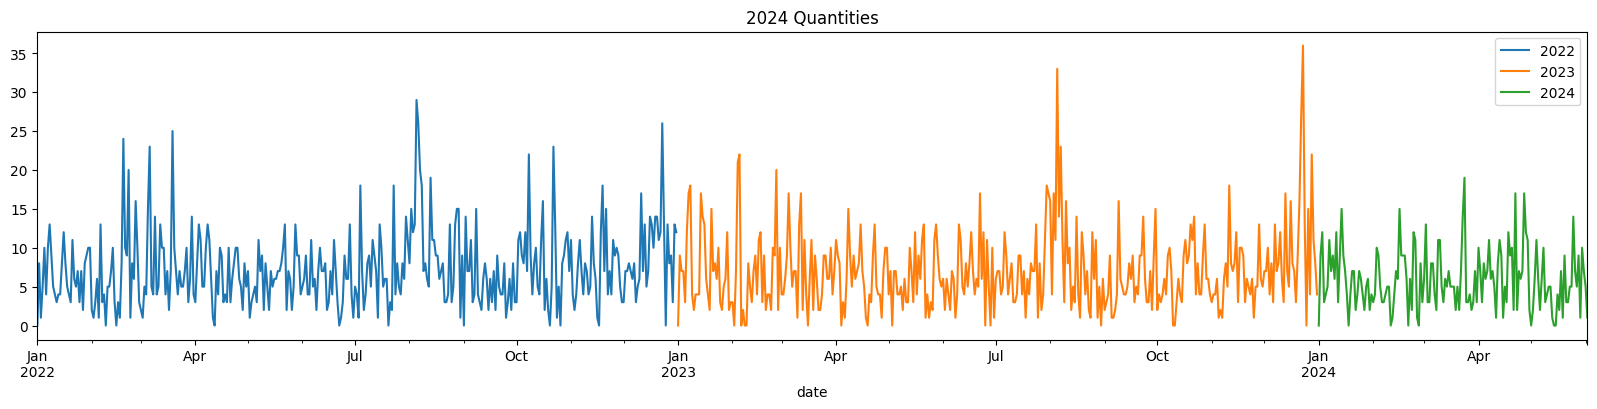

In [ ]:
for year in range(2019, 2022):
  train.loc[str(year)]['qty'].plot(title=f'{year} Quantities', figsize=(20, 4), label=year)
plt.legend()
plt.show()
for year in range(2022, 2025):
  train.loc[str(year)]['qty'].plot(title=f'{year} Quantities', figsize=(20, 4), label=year)
plt.legend()
plt.show()

In [ ]:
def evaluate_preds(y, y_pred, label):
    '''
        Return RMSE, MAE, and sMAPE scores
        y, y_pred, and label may be tuples of same length for evaluation on
        multiple sets
    '''

    # Compute sMAPE
    def smape_score(y_true, y_pred):
      denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
      diff = np.abs(y_pred - y_true)
      mask = denominator != 0 # Avoid division by zero
      smape_val = np.mean(diff[mask] / denominator[mask]) * 100
      return smape_val

    trues = y if isinstance(y, (tuple)) else (y,)
    preds = y_pred if isinstance(y_pred, (tuple)) else (y_pred,)

    rmse = []
    mae = []
    smape = []

    for true, pred in zip(trues, preds):
      rmse.append(round(root_mean_squared_error(true, pred), 4))
      mae.append(round(mean_absolute_error(true, pred), 4))
      smape.append(round(smape_score(true, pred), 4))

    scores = pd.DataFrame({'RMSE': rmse, 'MAE': mae, 'sMAPE': smape})
    scores.index = label if isinstance(label, (tuple)) else (label,)

    return(scores)

## Holt-Winters Model

In [ ]:
# Returns test set forecast and train/test scores
def rolling_cv(train, test, params, label=''):
  fitteds = []
  forecasts = []
  train_scores = []
  test_scores = []

  def same_day_last_year(date):
    try:
        return date.replace(year=date.year - 1)
    except ValueError: # If Feb 29
        return date.replace(year=date.year - 1, day=28)

  for i in range(0, 364, 28):
    train_fold = pd.concat([train, test[:i]])
    test_fold = test[i:i + 28]

    mod = ExponentialSmoothing(
      train_fold + 1 if params['use_boxcox'] else train_fold,
      trend=params['trend'],
      damped_trend=params['damped_trend'],
      seasonal='add',
      seasonal_periods=params['seasonal_periods'],
      use_boxcox=params['use_boxcox'],
      freq='D'
    ).fit()

    fitted = mod.fittedvalues
    forecast = mod.forecast(28)
    if params['use_boxcox']:
      fitted -= 1
      forecast -= 1

    # Set forecasts for closed days (i.e. Christmas, New Year's Day) to 0
    forecast.loc[test_fold.index.isin(test_closed_days)] = 0

    fitteds.append(fitted)
    forecasts.append(forecast)
    train_scores.append(evaluate_preds(train_fold['qty'], fitted, f'Fold {i / 28}'))
    test_scores.append(evaluate_preds(test_fold['qty'], forecast, f'Fold {i / 28}'))

  train_scores = pd.concat(train_scores).mean().round(4).to_frame().T
  test_scores = pd.concat(test_scores).mean().round(4).to_frame().T
  train_scores.index = [f"H-W Train Scores ({label})"]
  test_scores.index = [f"H-W Test Scores ({label})"]

  return pd.concat(forecasts), pd.concat([train_scores, test_scores])

In [ ]:
# Grid Search for Holt-Winters
'''
results = []
hw_train = train[:-364]
hw_val = train[-364:]

seasonal_periods = [7, 364]
trend = ['add', None]
damped_trend = [False, True]
use_boxcox = [False, True]
for sp, t, dt, use_bc in itertools.product(seasonal_periods, trend, damped_trend, use_boxcox):
  if (t == None) and (dt == True):
    continue
  result = {
    'trend': t,
    'seasonal_periods': sp,
    'damped_trend': dt,
    'use_boxcox': use_bc,
  }
  forecast, scores = rolling_cv(hw_train, hw_val, result)

  result['avg_rmse'] = round(float(scores.iloc[1]['RMSE']), 4)
  results.append(result)
  print(result)

results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['avg_rmse'].idxmin()]
print("\nBest model by Average RMSE:")
print(best_model)
'''

'\nresults = []\nhw_train = train[:-364]\nhw_val = train[-364:]\n\nseasonal_periods = [7, 364]\ntrend = [\'add\', None]\ndamped_trend = [False, True]\nuse_boxcox = [False, True]\nfor sp, t, dt, use_bc in itertools.product(seasonal_periods, trend, damped_trend, use_boxcox):\n  if (t == None) and (dt == True):\n    continue\n  result = {\n    \'trend\': t,\n    \'seasonal_periods\': sp,\n    \'damped_trend\': dt,\n    \'use_boxcox\': use_bc,\n  }\n  forecast, scores = rolling_cv(hw_train, hw_val, result)\n\n  result[\'avg_rmse\'] = round(float(scores.iloc[1][\'RMSE\']), 4)\n  results.append(result)\n  print(result)\n\nresults_df = pd.DataFrame(results)\nbest_model = results_df.loc[results_df[\'avg_rmse\'].idxmin()]\nprint("\nBest model by Average RMSE:")\nprint(best_model)\n'

In [ ]:
# Plot forecast
def plot_forecast(forecast, title):
  plt.figure(figsize=(16, 4))
  train.iloc[-364:]['qty'].plot(label='Train')
  test['qty'].plot(label='Actual')
  forecast.plot(label='Forecast')
  for i in range(0, test.shape[0], 28):
    plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
  plt.title(f'Holt-Winters Forecast ({title})')
  plt.legend()
  plt.show()

,RMSE,MAE,sMAPE
H-W Train Scores (seasonal_periods = 7),4.1436,3.0611,57.0406
H-W Test Scores (seasonal_periods = 7),3.8564,2.9953,66.7483
Naïve Train Scores,4.4736,3.4149,59.4749
Naïve Test Scores,4.3680,3.3521,67.9012


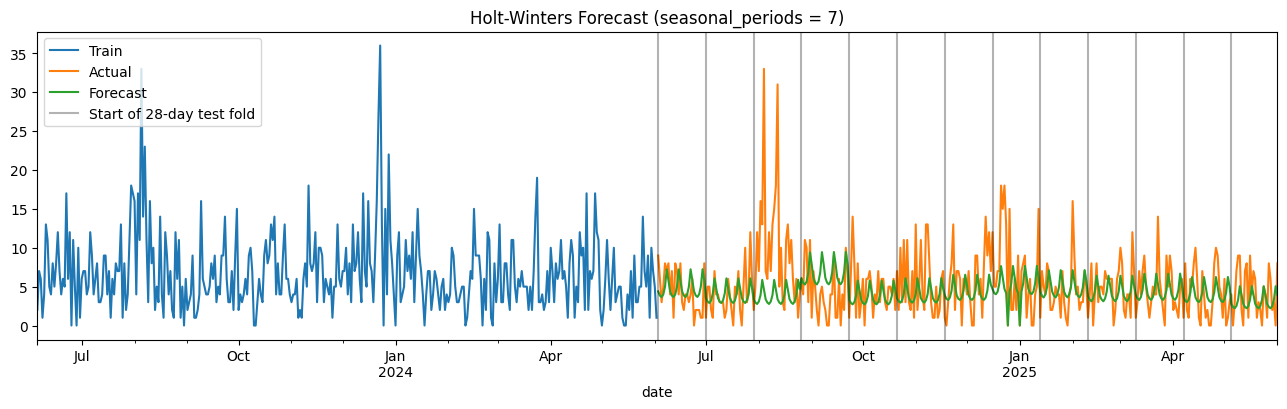

In [ ]:
# Fit model with best parameters for seasonal_periods = 7
params_7 = {'trend': 'add', 'seasonal_periods': 7, 'damped_trend': False, 'use_boxcox': True}
forecast_7, scores_7 = rolling_cv(train, test, params_7, label = 'seasonal_periods = 7')
display(pd.concat([scores_7, naive_scores]))
plot_forecast(forecast_7, 'seasonal_periods = 7')

,RMSE,MAE,sMAPE
H-W Train Scores (seasonal_periods = 364),3.5439,2.6773,51.8029
H-W Test Scores (seasonal_periods = 364),4.0378,3.2707,69.9316
H-W Train Scores (seasonal_periods = 7),4.1436,3.0611,57.0406
H-W Test Scores (seasonal_periods = 7),3.8564,2.9953,66.7483
Naïve Train Scores,4.4736,3.4149,59.4749
Naïve Test Scores,4.3680,3.3521,67.9012


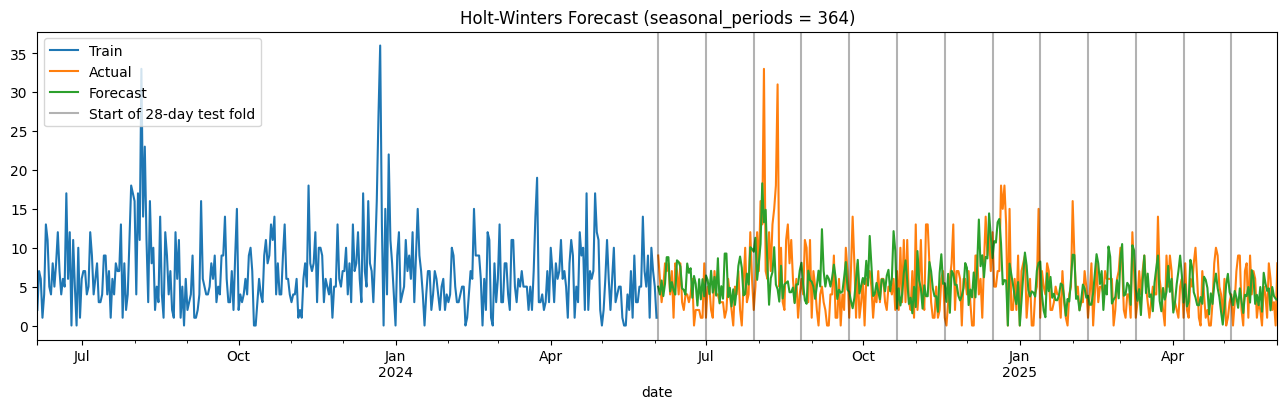

In [ ]:
# Fit model with best parameters for seasonal_periods = 364
params_364 = {'trend': None, 'seasonal_periods': 364, 'damped_trend': False, 'use_boxcox': False}
forecast_364, scores_364 = rolling_cv(train, test, params_364, label='seasonal_periods = 364')
display(pd.concat([scores_364, scores_7, naive_scores]))
plot_forecast(forecast_364, 'seasonal_periods = 364')

# Holt-Winters Weighted Average Ensemble

Forecast using a weighted average of the forecasts from the previous two models with seasonal_periods 7 and 364

forecast_ensemble = alpha * forecast_val_7 + (1 - alpha) * forecast_val_364

where alpha is between 0 to 1

In [ ]:
# Grid Search for Holt-Winters
'''
results = []
hw_train = train[:-364]
hw_val = train[-364:]

forecast_val_7, _ = rolling_cv(hw_train, hw_val, params_7)
forecast_val_364, _ = rolling_cv(hw_train, hw_val, params_364)

for alpha in range(1, 10):
  alpha /= 10
  result = {
      'alpha': alpha,
  }
  rmses = []
  i = 0
  forecast_val = alpha * forecast_val_7 + (1 - alpha) * forecast_val_364
  while i < 364:
    rmses.append(root_mean_squared_error(hw_val[i:i + 28], forecast_val[i:i + 28]))
    i += 28

  result['avg_rmse'] = round(float(np.mean(rmses)), 4)
  results.append(result)
  print(result)

results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['avg_rmse'].idxmin()]
print("\nBest model by Average RMSE:")
print(best_model)
'''

'\nresults = []\nhw_train = train[:-364]\nhw_val = train[-364:]\n\nforecast_val_7, _ = rolling_cv(hw_train, hw_val, params_7)\nforecast_val_364, _ = rolling_cv(hw_train, hw_val, params_364)\n\nfor alpha in range(1, 10):\n  alpha /= 10\n  result = {\n      \'alpha\': alpha,\n  }\n  rmses = []\n  i = 0\n  forecast_val = alpha * forecast_val_7 + (1 - alpha) * forecast_val_364\n  while i < 364:\n    rmses.append(root_mean_squared_error(hw_val[i:i + 28], forecast_val[i:i + 28]))\n    i += 28\n\n  result[\'avg_rmse\'] = round(float(np.mean(rmses)), 4)\n  results.append(result)\n  print(result)\n\nresults_df = pd.DataFrame(results)\nbest_model = results_df.loc[results_df[\'avg_rmse\'].idxmin()]\nprint("\nBest model by Average RMSE:")\nprint(best_model)\n'

In [ ]:
forecast_avg = (forecast_7 + forecast_364) / 2
scores_avg = []
for i in range(0, 364, 28):
  scores_avg.append(evaluate_preds(test[i:i + 28]['qty'], forecast_avg[i:i + 28], 'H-W Ensemble Test Scores'))
scores_avg = pd.concat(scores_avg).mean().round(4).to_frame().T
scores_avg.index = ['H-W Test Scores (ensemble)']
display(pd.concat([scores_avg, scores_7.iloc[[1]], scores_364.iloc[[1]], naive_scores.iloc[[1]]]))

,RMSE,MAE,sMAPE
H-W Test Scores (ensemble),3.7633,2.9712,65.9368
H-W Test Scores (seasonal_periods = 7),3.8564,2.9953,66.7483
H-W Test Scores (seasonal_periods = 364),4.0378,3.2707,69.9316
Naïve Test Scores,4.3680,3.3521,67.9012


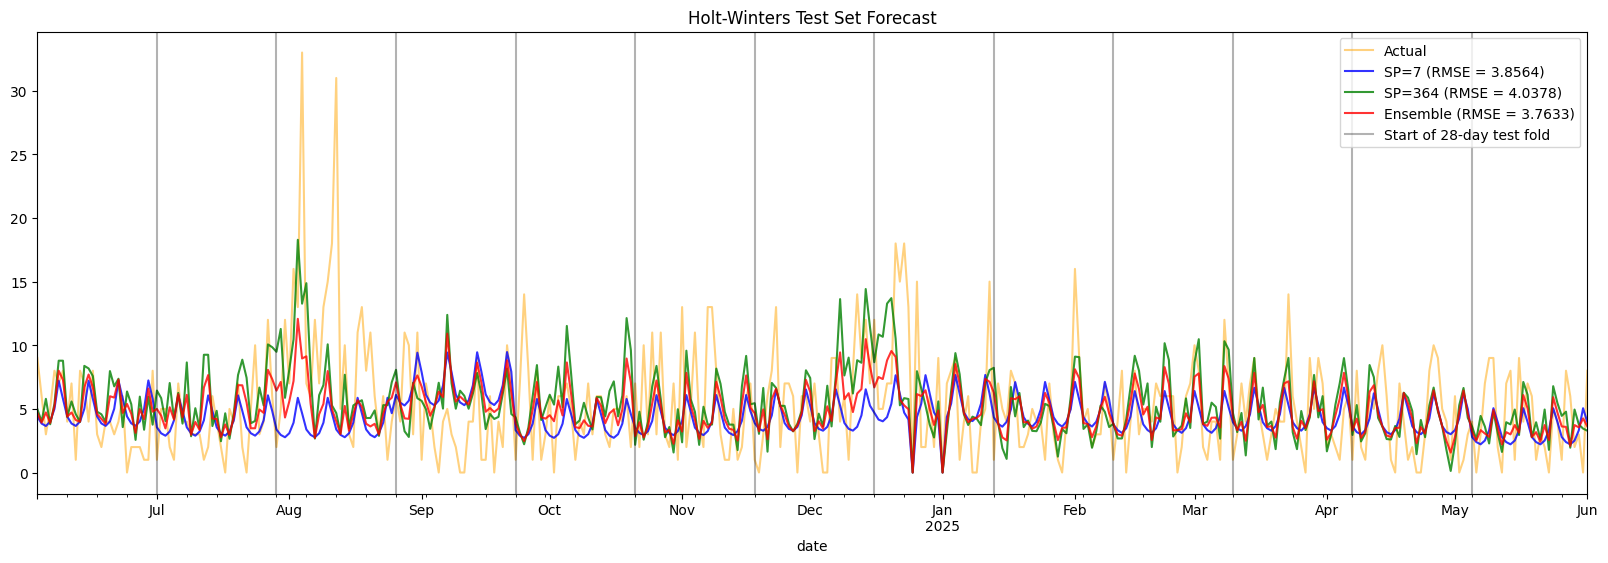

In [ ]:
plt.figure(figsize=(20, 6))
test['qty'].plot(label='Actual', alpha=0.5, color='orange')
forecast_7.plot(label=f"SP=7 (RMSE = {scores_7.iloc[1]['RMSE']})", alpha=0.8, color='blue')
forecast_364.plot(label=f"SP=364 (RMSE = {scores_364.iloc[1]['RMSE']})", alpha=0.8, color='green')
forecast_avg.plot(label=f"Ensemble (RMSE = {scores_avg.iloc[0]['RMSE']})", alpha=0.8, color='red')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)

plt.title(f'Holt-Winters Test Set Forecast')
plt.legend()
plt.show()

In [ ]:
train.index[-364:]

DatetimeIndex(['2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08',
               '2023-06-09', '2023-06-10', '2023-06-11', '2023-06-12',
               '2023-06-13', '2023-06-14',
               ...
               '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27',
               '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31',
               '2024-06-01', '2024-06-02'],
              dtype='datetime64[ns]', name='date', length=364, freq=None)

In [ ]:
# Fit models on training dataset for seasonal_periods = 7 and 364, and get the time to fit the model
start_time = time.time()

mod_7 = ExponentialSmoothing(
  train + 1,
  trend='add',
  damped_trend=False,
  seasonal='add',
  seasonal_periods=7,
  use_boxcox=True,
  freq='D'
).fit()

print(f"Fit time (seasonal_periods = 7): {round(time.time() - start_time, 2)} seconds")
start_time = time.time()

mod_364 = ExponentialSmoothing(
  train,
  trend=None,
  damped_trend=False,
  seasonal='add',
  seasonal_periods=364,
  use_boxcox=False,
  freq='D'
).fit()

print(f"Fit time (seasonal_periods = 364): {round(time.time() - start_time, 2)} seconds")

Fit time (seasonal_periods = 7): 0.5 seconds
Fit time (seasonal_periods = 364): 1.24 seconds


## Trend and Seasonality Plots

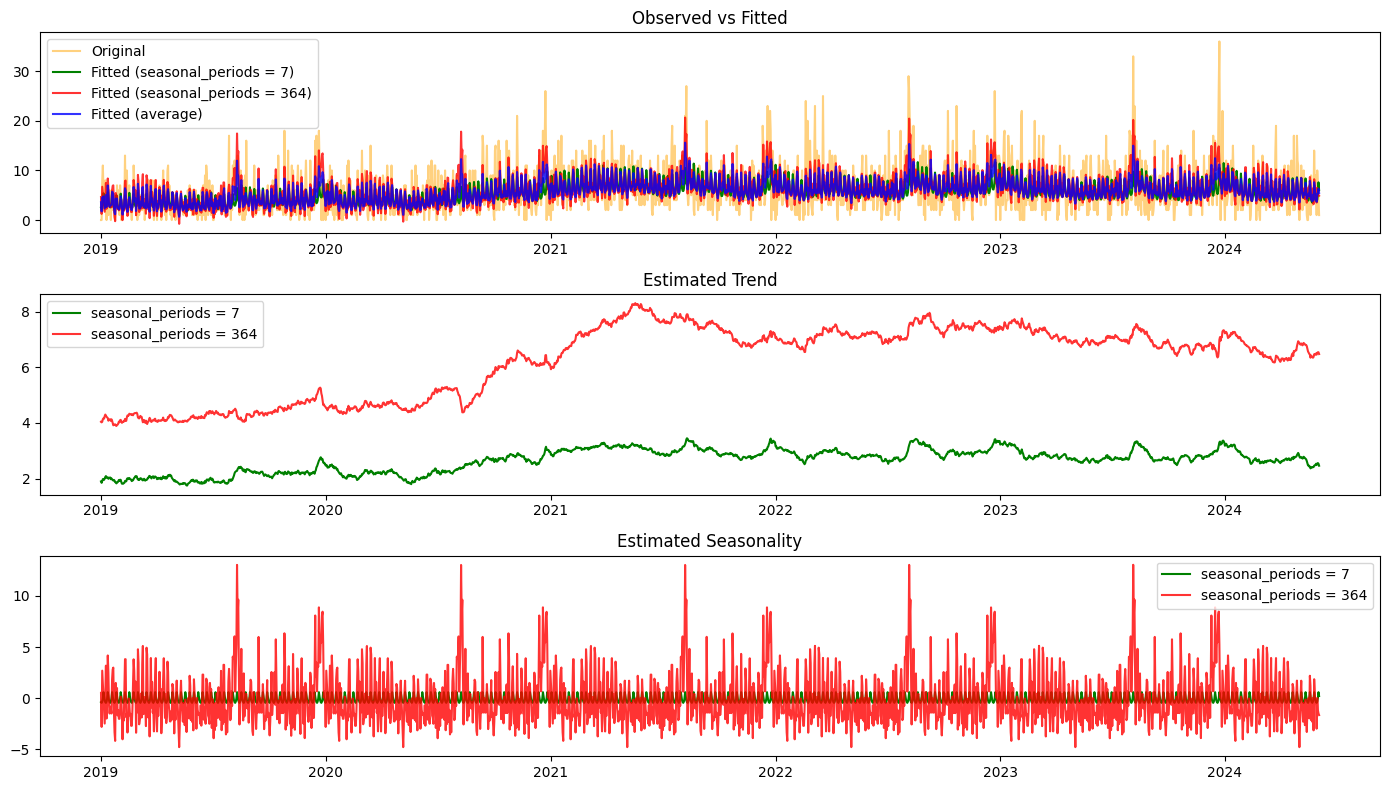

In [ ]:
# Plot fitted, trend, and seasonality

fitted_7 = mod_7.fittedvalues - 1
trend_7 = mod_7.level
seasonal_7 = mod_7.season

fitted_364 = mod_364.fittedvalues
trend_364 = mod_364.level
seasonal_364 = mod_364.season

fitted_avg = (fitted_7 + fitted_364) / 2
trend_avg = (trend_7 + trend_364) / 2
seasonal_avg = (seasonal_7 + seasonal_364) / 2

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(train['qty'], label='Original', alpha=0.5, color='orange')
plt.plot(fitted_7, label='Fitted (seasonal_periods = 7)', color='green')
plt.plot(fitted_364, label='Fitted (seasonal_periods = 364)', alpha=0.8, color='red')
plt.plot(fitted_avg, label='Fitted (average)', alpha=0.8, color='blue')
plt.title('Observed vs Fitted')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(trend_7, label='seasonal_periods = 7', color='green')
plt.plot(trend_364, label='seasonal_periods = 364', alpha=0.8, color='red')
plt.title('Estimated Trend')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(seasonal_7, label='seasonal_periods = 7', color='green')
plt.plot(seasonal_364, label='seasonal_periods = 364', alpha=0.8, color='red')
plt.title('Estimated Seasonality')
plt.legend()

plt.tight_layout()
plt.show()

## Residual Analysis

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

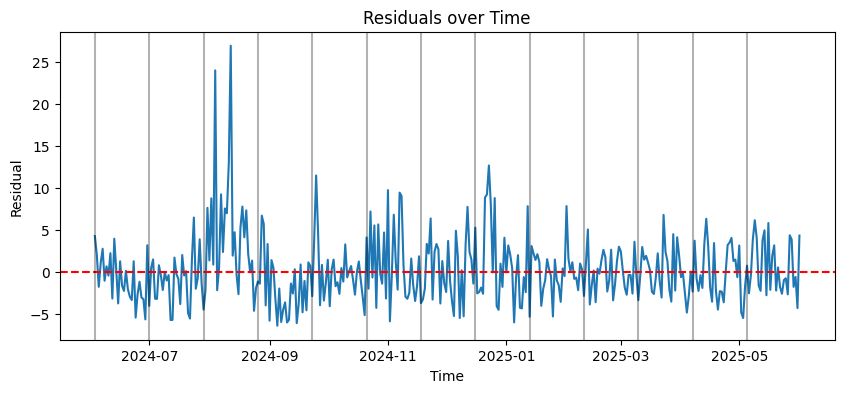

In [ ]:
residuals = test['qty'] - forecast_avg

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
plt.show()

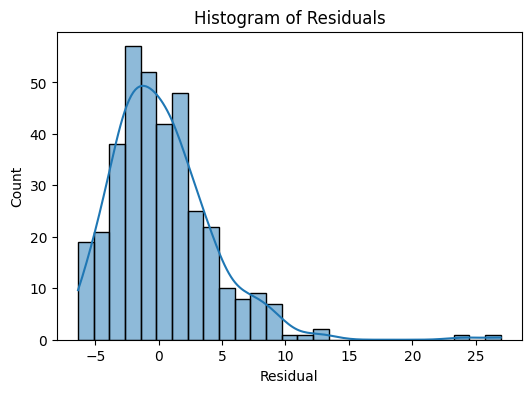

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.show()

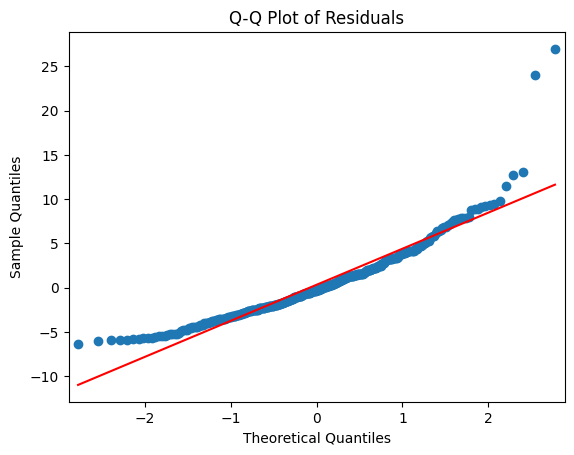

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

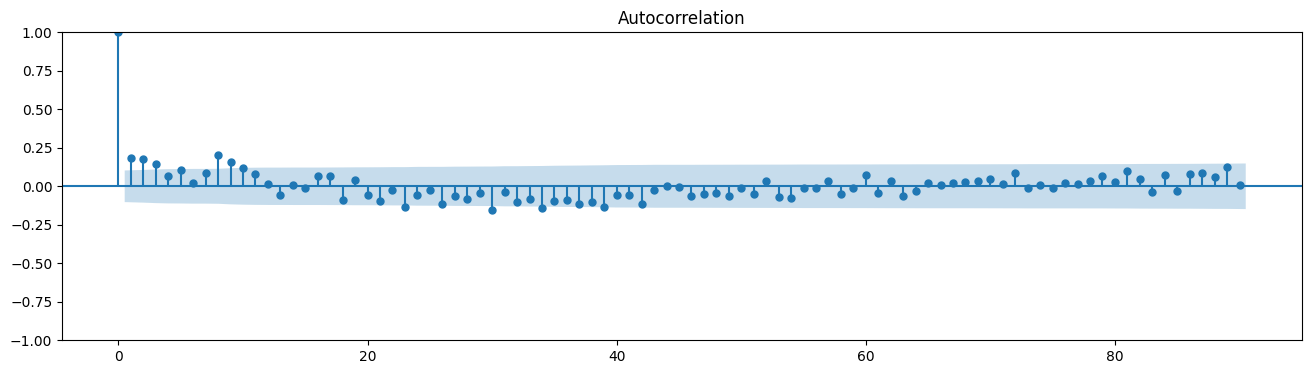

In [ ]:
plot_acf(residuals, lags=90).set_size_inches(16, 4)
plt.show()

In [ ]:
acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)

,lb_stat,lb_pvalue
10,70.798393,3.108254e-11
20,83.153138,1.137443e-09
30,114.958617,7.047050e-12


In [ ]:
#@title Export Best Test Forecasts to CSV File

best_forecast = forecast_avg.rename('forecast')
best_forecast.to_csv(f'{path}forecast_holt_winters.csv', index=True, index_label='date')